Introduction To NLP @ Esade BAIB

# Named Entity Recognition with Spacy

----

# Spacy NLP 

https://spacy.io/usage/spacy-101

## Preliminaries

To run this notebook first install `spacy` and one of the spacy language models:

```
python -m pip install --upgrade spacy
python -m spacy download en_core_web_md

```


In [1]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 300)
from tqdm import tqdm

In [2]:
import spacy
spacy_nlp = spacy.load('en_core_web_md')

## Process docs with NLP pipeline

![](https://spacy.io/images/pipeline.svg)

In [3]:
reviews_df = pd.read_csv('../data/movie_reviews_train.csv')

In [4]:
len(reviews_df)

9595

In [6]:
# This step is expensive, adjust N to your computing 
N=10000  
reviews_nlp = [spacy_nlp(t) for t in tqdm(reviews_df.text[:N])]


100%|██████████| 9595/9595 [01:18<00:00, 122.10it/s]


In [7]:
d1 = spacy_nlp("Paris Jackson went to John Smith's house.")

In [9]:
for e in d1.ents:
    print(e.text, e.label_)

Paris GPE
Jackson PERSON
John Smith's PERSON


## Tokens, pos tags, noun chunks, entities

### Pick a sentence and inspect

In [10]:
sentence = reviews_nlp[15]

In [12]:
sentence

the images are usually abbreviated in favor of mushy obviousness and telegraphed pathos , particularly where whitaker's misfit artist is concerned .

In [14]:
sentence[3].lemma_

'usually'

In [15]:
[(i, t.text, t.lemma_,t.tag_,t.ent_type_) for i,t in enumerate(sentence)]

[(0, 'the', 'the', 'DT', ''),
 (1, 'images', 'image', 'NNS', ''),
 (2, 'are', 'be', 'VBP', ''),
 (3, 'usually', 'usually', 'RB', ''),
 (4, 'abbreviated', 'abbreviate', 'VBN', ''),
 (5, 'in', 'in', 'IN', ''),
 (6, 'favor', 'favor', 'NN', ''),
 (7, 'of', 'of', 'IN', ''),
 (8, 'mushy', 'mushy', 'JJ', ''),
 (9, 'obviousness', 'obviousness', 'NN', ''),
 (10, 'and', 'and', 'CC', ''),
 (11, 'telegraphed', 'telegraph', 'VBN', ''),
 (12, 'pathos', 'pathos', 'NN', ''),
 (13, ',', ',', ',', ''),
 (14, 'particularly', 'particularly', 'RB', ''),
 (15, 'where', 'where', 'WRB', ''),
 (16, 'whitaker', 'whitaker', 'NN', 'PERSON'),
 (17, "'s", "'s", 'POS', ''),
 (18, 'misfit', 'misfit', 'NN', ''),
 (19, 'artist', 'artist', 'NN', ''),
 (20, 'is', 'be', 'VBZ', ''),
 (21, 'concerned', 'concern', 'VBN', ''),
 (22, '.', '.', '.', '')]

### Entities

In [16]:
def display_sentence_and_entities(sentence):
    print('SENTENCE', sentence)
    for e in sentence.ents:
        print('ENTITY', e, 'TYPE', e.label_, 'TEXT', e.text, 'LEMMA', e.text)

In [17]:
display_sentence_and_entities(reviews_nlp[15])

SENTENCE the images are usually abbreviated in favor of mushy obviousness and telegraphed pathos , particularly where whitaker's misfit artist is concerned .
ENTITY whitaker TYPE PERSON TEXT whitaker LEMMA whitaker


In [19]:
display_sentence_and_entities(reviews_nlp[86])

SENTENCE delia , greta , and paula rank as three of the most multilayered and sympathetic female characters of the year . as each of them searches for their place in the world , miller digs into their very minds to find an unblinking , flawed humanity .
ENTITY delia TYPE PERSON TEXT delia LEMMA delia
ENTITY greta TYPE PERSON TEXT greta LEMMA greta
ENTITY paula TYPE PERSON TEXT paula LEMMA paula
ENTITY three TYPE CARDINAL TEXT three LEMMA three
ENTITY the year TYPE DATE TEXT the year LEMMA the year
ENTITY miller TYPE ORG TEXT miller LEMMA miller


### List Nouns and Adjectives

In [20]:
[(t.lemma_, t.tag_) for t in sentence if t.tag_ in ['JJ', 'NN', 'NNP']]

[('favor', 'NN'),
 ('mushy', 'JJ'),
 ('obviousness', 'NN'),
 ('pathos', 'NN'),
 ('whitaker', 'NN'),
 ('misfit', 'NN'),
 ('artist', 'NN')]

### Noun Chunks (shallow noun phrases)

In [21]:
list(sentence.noun_chunks)

[the images,
 favor,
 mushy obviousness,
 telegraphed pathos,
 whitaker's misfit artist]

## Syntactic Trees

In [22]:
from spacy import displacy
displacy.render(sentence, style="dep")

## Aggregate entities over documents

We'll now compute a dataframe that counts how many times each distinct entity appears in the data. We will also keep track of the label of the movie review (positive or negative review), and
for each entity we'll keep a count of the number of times it was observed in a positive/negative review. 

Are there actors highly correlated with positive or negative reviews?

In [23]:
def spacy_entity_to_dict(doc_label, entity):
    return {
        'text': entity.text, 
        'lemma': entity.lemma_,
        'ner_type': entity.label_,
        doc_label: 1
    }

def entity_aggregation_for_spacy_docs(docs_df, docs_nlp):
    entities = pd.DataFrame([spacy_entity_to_dict(l, e) for doc,l in zip(docs_nlp, docs_df.label) for e in doc.ents]).fillna(0)
    agg_dict = {
        'num_docs': pd.NamedAgg('text', 'count')
    }
    for l in set(docs_df.label):
        agg_dict[f'num_{l}'] = pd.NamedAgg(l, 'sum')
    agg = entities.groupby(['lemma', 'ner_type'], as_index=False).agg(**agg_dict).sort_values('num_docs', ascending=False)
    return agg

In [24]:
entities_agg = entity_aggregation_for_spacy_docs(reviews_df, reviews_nlp)

In [25]:
entities_agg.head()

,lemma,ner_type,num_docs,num_positive,num_negative
2078,one,CARDINAL,312,157.0,155.0
1085,first,ORDINAL,143,86.0,57.0
2807,two,CARDINAL,120,67.0,53.0
1304,hollywood,GPE,102,50.0,52.0
394,american,NORP,100,65.0,35.0


In [27]:
entities_agg[entities_agg.ner_type.isin(['ORG', 'PERSON', 'GPE'])].sort_values('num_positive', ascending=False)

,lemma,ner_type,num_docs,num_positive,num_negative
1304,hollywood,GPE,102,50.0,52.0
393,america,GPE,21,15.0,6.0
1392,jackson,PERSON,14,11.0,3.0
2529,spielberg,PERSON,12,11.0,1.0
1901,miller,ORG,12,10.0,2.0
...,...,...,...,...,...
2939,worshipful bio-doc,PERSON,1,0.0,1.0
2940,wwf,PERSON,1,0.0,1.0
2919,william malone,PERSON,1,0.0,1.0
2920,william randolph hearst,PERSON,1,0.0,1.0


# AG News

In [29]:
ag_news = pd.read_csv('../data/agnews_train.csv')

In [30]:
# This step is expensive, adjust N to your compute power
N_ag = 10000
ag_nlp = [spacy_nlp(text) for text in tqdm(ag_news.text[:N_ag]) ]

100%|██████████| 10000/10000 [01:41<00:00, 98.78it/s]


In [31]:
ag_ents = entity_aggregation_for_spacy_docs(ag_news, ag_nlp)

In [32]:
ag_ents

,lemma,ner_type,num_docs,num_Sports,num_World,num_Business,num_Science
1060,39;s,MONEY,1123,265.0,248.0,394.0,216.0
9409,Reuters,ORG,917,100.0,308.0,402.0,107.0
11102,Tuesday,DATE,581,120.0,164.0,202.0,95.0
10911,Thursday,DATE,562,103.0,163.0,194.0,102.0
11198,US,GPE,552,60.0,184.0,240.0,68.0
...,...,...,...,...,...,...,...
15900,western Australian Cricket Association,ORG,1,1.0,0.0,0.0,0.0
15901,western Germany,GPE,1,0.0,1.0,0.0,0.0
15902,white MP,ORG,1,0.0,1.0,0.0,0.0
15903,wil Wheaton,ORG,1,0.0,0.0,0.0,1.0


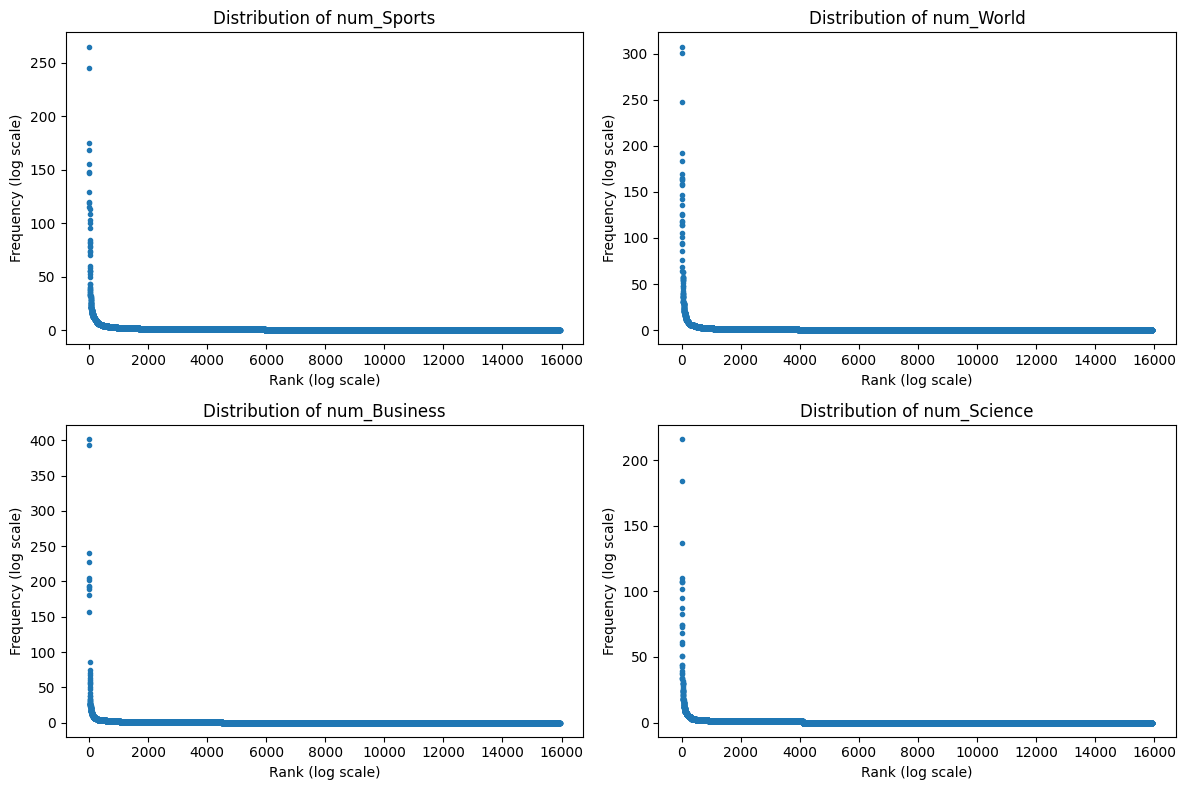


Statistics for num_Sports:
Total entities with non-zero counts: 5944
Total occurrences: 15377.0


KeyError: "['Entity'] not in index"

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ag_ents is the DataFrame from entity_aggregation_for_spacy_docs
# Columns to analyze
columns = ['num_Sports', 'num_World', 'num_Business', 'num_Science']

# Create a figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten for easier iteration

# Process each column
for idx, col in enumerate(columns):
    # Extract and sort values in descending order
    counts = ag_ents[col].dropna().sort_values(ascending=False).values
    # Create rank indices (1, 2, 3, ...)
    ranks = range(1, len(counts) + 1)

    # Plot on a log-log scale
    axes[idx].plot(ranks, counts, marker='.', linestyle='none')
    axes[idx].set_xlabel('Rank (log scale)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {col}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Optional: Summary statistics for each column
for col in columns:
    counts = ag_ents[col].dropna()
    print(f"\nStatistics for {col}:")
    print(f"Total entities with non-zero counts: {len(counts[counts > 0])}")
    print(f"Total occurrences: {counts.sum()}")
    print(f"Top 5 entities:\n{ag_ents[['Entity', col]].sort_values(by=col, ascending=False).head(5)}")

In [36]:
headlines = ['In its pursuit of a policy, Donald Trump’s government is content to destroy a man',
             'Zuckerberg on trial: why Meta deserves to win',
             'Mario Vargas Llosa was shaped by authoritarianism',
             'TikTok’s bizarre sale process gets even weirder',
             'The thing about Europe: it’s the actual land of the free now']

for headline in headlines:
    a = spacy_nlp(headline)
    for e in a.ents:
        print(headline, e.text, e.label_)


In its pursuit of a policy, Donald Trump’s government is content to destroy a man Donald Trump’s PERSON
Zuckerberg on trial: why Meta deserves to win Zuckerberg PERSON
Zuckerberg on trial: why Meta deserves to win Meta ORG
Mario Vargas Llosa was shaped by authoritarianism Mario Vargas Llosa PERSON
TikTok’s bizarre sale process gets even weirder TikTok ORG
The thing about Europe: it’s the actual land of the free now Europe LOC
